In [1]:
import numpy as np
import pandas as pd
import cv2
from glob import glob

In [2]:
images_path='C:\\Users\\Rishav\\Image caption\\Images\\' 
images=glob(images_path + '*.jpg')#reading all images ending with jpg
len(images)

8091

In [3]:
images[:5]

['C:\\Users\\Rishav\\Image caption\\Images\\1000268201_693b08cb0e.jpg',
 'C:\\Users\\Rishav\\Image caption\\Images\\1001773457_577c3a7d70.jpg',
 'C:\\Users\\Rishav\\Image caption\\Images\\1002674143_1b742ab4b8.jpg',
 'C:\\Users\\Rishav\\Image caption\\Images\\1003163366_44323f5815.jpg',
 'C:\\Users\\Rishav\\Image caption\\Images\\1007129816_e794419615.jpg']

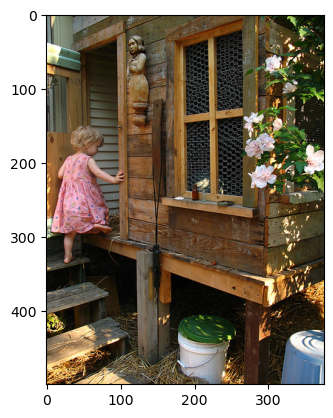

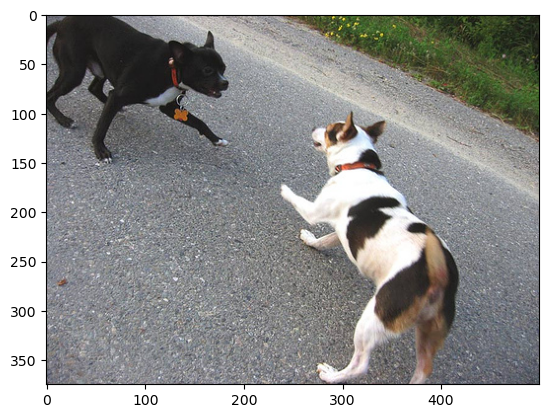

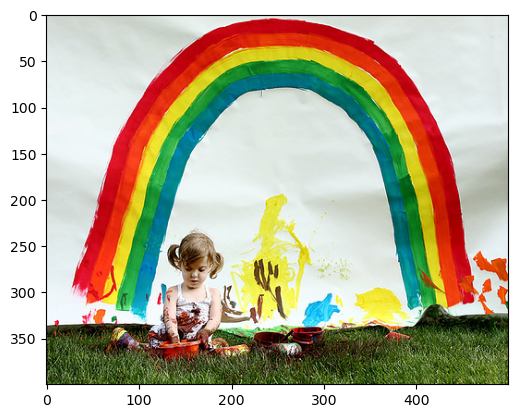

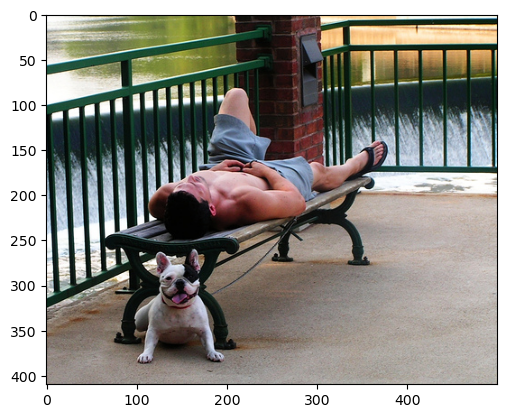

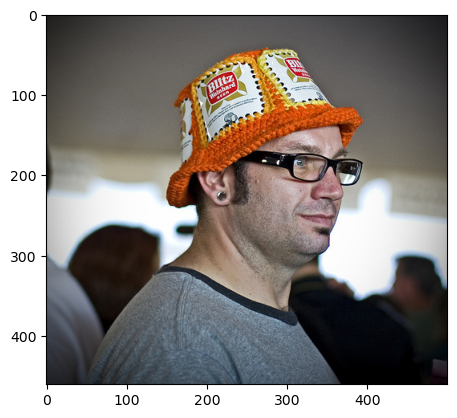

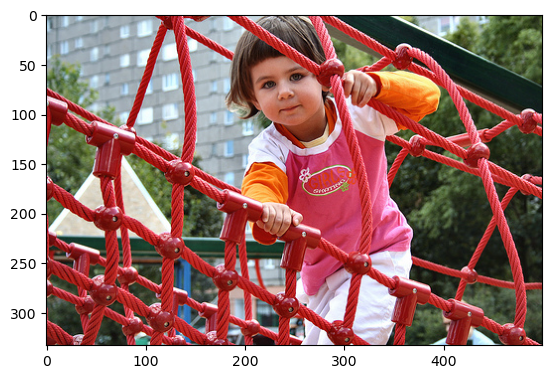

In [4]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.figure()
    img=cv2.imread(images[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#showing the images by converting in to RGB first
    plt.imshow(img)

In [5]:
from keras.applications import ResNet50 #downloding ResNet50
incept_model=ResNet50(include_top=True)

In [6]:
incept_model.summary() #summary of ResNet50 model

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [7]:
from keras.models import Model
last=incept_model.layers[-2].output
modele=Model(inputs=incept_model.inputs,outputs=last)#removing the last layer in the model
modele.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [8]:
images_features={} #data preprocessing Starts
count=0
for i in images:
    img=cv2.imread(i)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#conerting the given images to RGB
    img=cv2.resize(img,(224,224))
    
    img=img.reshape(1,224,224,3)
    pred=modele.predict(img).reshape(2048)#returning the values as 2048 vector
     
    img_name=i.split('/')[-1] #slicing the image name
    images_features[img_name]=pred#adding the image feature to the dictionary
    
    count=count+1
    
    if count>2000:
        break
    elif count % 50 == 0:
        print(count)

1/1 [==============================] - 0s 85ms/step
50
1/1 [==============================] - 0s 87ms/step
100
1/1 [==============================] - 0s 86ms/step
150
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 87ms/step
200
1/1 [==============================] - 0s 89ms/step
250
1/1 [==============================] - 0s 87ms/step
300
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 83ms/step
350
1/1 [==============================] - 0s 86ms/step
400
1/1 [==============================] - 0s 87ms/step
450
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 89ms/step
500
1/1 [==============================] - 0s 90ms/step
550
1/1 [==============================] - 0s 89ms/step
600
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 89ms/step
650
1/1 [==============================] - 0s 90ms/step
700
1/1 [==============================] - 0s 92ms/step
750
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 91ms/step
800
1/1 [==============================] - 0s 91ms/step
850
1/1 [==============================] - 0s 101ms/step
900
1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 96ms/step
950
1/1 [==============================] - 0s 95ms/step
1000
1/1 [==============================] - 0s 108ms/step
1050
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 99ms/step
1100
1/1 [==============================] - 0s 104ms/step
1150
1/1 [==============================] - 0s 117ms/step
1200
1/1 [==============================] - 0s 113ms/step
1250
1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 122ms/step
1300
1/1 [==============================] - 0s 157ms/step
1350
1/1 [==============================] - 0s 151ms/step
1400
1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 154ms/step
1450
1/1 [==============================] - 0s 163ms/step
1500
1/1 [==============================] - 0s 158ms/step
1550
1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 162ms/step
1600
1/1 [==============================] - 0s 167ms/step
1650
1/1 [==============================] - 0s 174ms/step
1700
1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 176ms/step
1750
1/1 [==============================] - 0s 182ms/step
1800
1/1 [==============================] - 0s 184ms/step
1850
1/1 [==============================] - 0s 199ms/step


1/1 [==============================] - 0s 197ms/step
1900
1/1 [==============================] - 0s 206ms/step
1950
1/1 [==============================] - 0s 214ms/step
2000
1/1 [==============================] - 0s 215ms/step


In [75]:
caption_path = 'C:\\Users\\Rishav\\Image caption\\captions.txt'#text preprocessing starts
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')#splitting the captions
len(captions)

40456

In [76]:
captions

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a 

In [77]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split(',')[0]
        caption = i.split(',')[1]
        if img_name not in captions_dict:
            captions_dict[img_name] = [caption]
                
        else:
            captions_dict[img_name].append(caption)
            
    except:
        pass

In [72]:
captions_dict

{'1000268201_693b08cb0e.jpg': ['A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a girl with pigtails sitting in front of a rainbow painting .',
  'You

In [43]:
captions[0]=captions[0].split(',')

In [45]:
img_name=captions[0][0]

In [46]:
captions[0]

['1000268201_693b08cb0e.jpg',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [47]:
img_name

'1000268201_693b08cb0e.jpg'